In [91]:
import pandas as pd
import os

from dotenv import load_dotenv
import seaborn as sns
from matplotlib import pyplot as plt
from parea import Parea

load_dotenv()


p = Parea(api_key=os.getenv("PAREA_API_KEY"))


def analysis(experiment_uuid: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    experiment_stats = p.get_experiment_stats(experiment_uuid)

    dicts = []
    for stats in experiment_stats.parent_trace_stats:
        d = {'trace_id': stats.trace_id}
        for score in stats.scores:
            d[score.name] = score.score
        dicts.append(d)

    df = pd.DataFrame(dicts)
    df_scores = df.copy()
    del df_scores['trace_id']

    df_acc = df_scores.eq(df_scores['hit_rate_top_20'], axis=0).sum() / len(df_scores)
    df_fpr = df_scores.apply(lambda x: (x == 1) & (df_scores['hit_rate_top_20'] == 0)).sum() / len(df_scores)
    df_fnr = df_scores.apply(lambda x: (x == 0) & (df_scores['hit_rate_top_20'] == 1)).sum() / len(df_scores)
    df_comp = pd.concat([df_acc, df_fpr, df_fnr], axis=1, keys=['accuracy', 'fpr', 'fnr'])

    return df_comp


def create_plot(qa_with_thoughts, qa_wo_thoughts):
    dicts = []
    for (with_thoughts, wo_thoughts) in zip(qa_with_thoughts, qa_wo_thoughts):
        wi_t = {k: v for k, v in with_thoughts['accuracy'].to_dict().items() if k != 'hit_rate_top_20'}
        wo_t = {k: v for k, v in wo_thoughts['accuracy'].to_dict().items() if k != 'hit_rate_top_20'}

        for eval_metric in wi_t.keys():
            # dicts.append({'with_thoughts': wi_t[eval_metric], 'without_thoughts': wo_t[eval_metric], 'eval_metric': eval_metric, 'diff': wi_t[eval_metric] - wo_t[eval_metric]})
            eval_name = eval_metric.replace('gpt_35_turbo_0125_', '')
            dicts.append({'accuracy': wi_t[eval_metric], 'eval_metric': eval_name, 'with_thoughts': True})
            dicts.append({'accuracy': wo_t[eval_metric], 'eval_metric': eval_name, 'with_thoughts': False})

    df = pd.DataFrame(dicts)

    plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
    sns.barplot(data=df, x='eval_metric', y='accuracy', hue='with_thoughts')

    return df

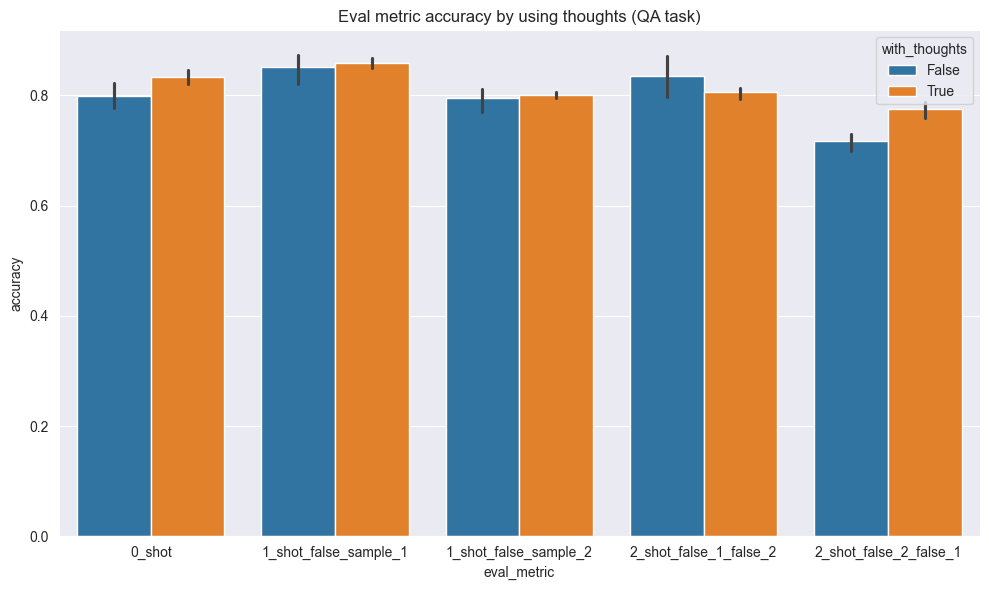

In [93]:
bge_qa_with_thoughts = analysis('1780cc81-825f-4273-91ee-01151473d41c')
oai_ada_002_qa_with_thoughts = analysis('b442feb3-d699-4d35-a41d-932d895f1c39')
oai_small_min_qa_with_thoughts = analysis('3aa6a7ae-28bb-4570-92c2-9a8347f42cb9')
oai_small_max_qa_with_thoughts = analysis('192b0f86-aca5-4e7e-b251-85a89ea975d8')
oai_large_min_qa_with_thoughts = analysis('64518f1b-9f77-4daf-a316-c3671e42f4d8')
oai_large_max_qa_with_thoughts = analysis('8704644b-db26-4b44-8c61-778eeaec59d4')
qa_with_thoughts = [bge_qa_with_thoughts, oai_ada_002_qa_with_thoughts, oai_small_min_qa_with_thoughts, oai_small_max_qa_with_thoughts, oai_large_min_qa_with_thoughts, oai_large_max_qa_with_thoughts]

bge_qa_wo_thoughts = analysis('934965e9-6dc0-4557-ac51-2ea59ad1d2dc')
oai_ada_002_qa_wo_thoughts = analysis('72d97dd5-4798-40a6-98fd-12c06e6432a4')
oai_small_min_qa_wo_thoughts = analysis('9be4e38b-7a0a-45a0-b485-4cbdb645ddcb')
oai_small_max_qa_wo_thoughts = analysis('af468dd3-7ef5-4370-a7a4-386abcf08a98')
oai_large_min_qa_wo_thoughts = analysis('75cafa9e-2b99-4571-a425-ca5a47ae8d57')
oai_large_max_qa_wo_thoughts = analysis('2ba174db-2333-4723-91a9-e31c8ce507c5')
qa_wo_thoughts = [bge_qa_wo_thoughts, oai_ada_002_qa_wo_thoughts, oai_small_min_qa_wo_thoughts, oai_small_max_qa_wo_thoughts, oai_large_min_qa_wo_thoughts, oai_large_max_qa_wo_thoughts]

# create_plots(axs, qa_with_thoughts, qa_wo_thoughts, min_val=0.6)
df_qa = create_plot(qa_with_thoughts, qa_wo_thoughts)
plt.title('Eval metric accuracy by using thoughts (QA task)')
plt.tight_layout()
plt.savefig('ablation-using-thoughts-qa.png')
plt.show()

In [81]:
df_qa.groupby(['eval_metric', 'with_thoughts']).agg(['mean', 'std']).round(2)

accuracy      
                                         mean   std
eval_metric            with_thoughts               
0_shot                 False             0.80  0.03
                       True              0.83  0.02
1_shot_false_sample_1  False             0.85  0.04
                       True              0.86  0.01
1_shot_false_sample_2  False             0.80  0.03
                       True              0.80  0.01
2_shot_false_1_false_2 False             0.84  0.05
                       True              0.81  0.01
2_shot_false_2_false_1 False             0.72  0.02
                       True              0.78  0.02

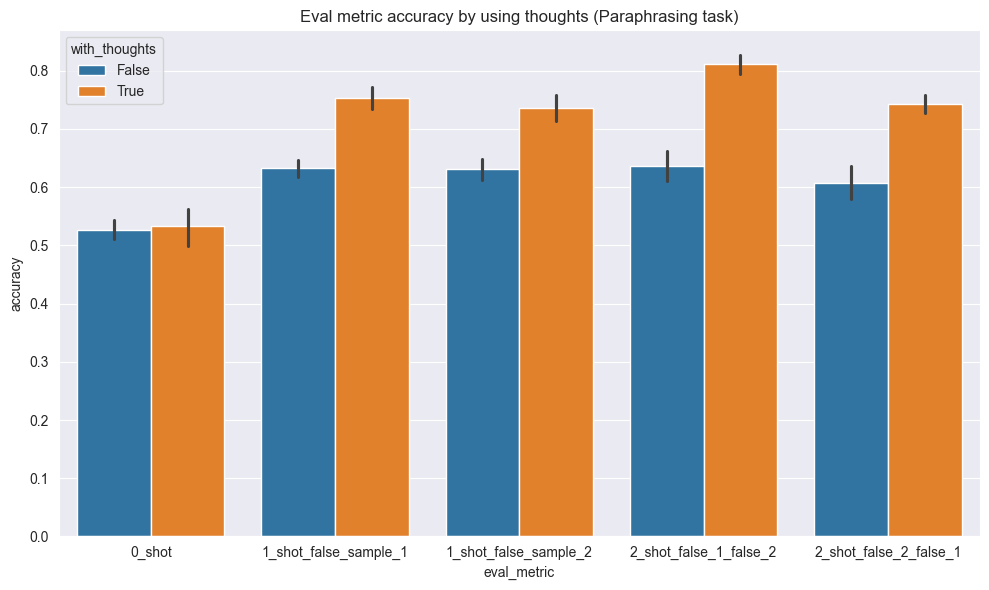

In [94]:
import seaborn as sns
from matplotlib import pyplot as plt

bge_para_with_thoughts = analysis('e48d3ea3-1d92-498e-82bb-7967b49d6a9b')
oai_ada_002_para_with_thoughts = analysis('c849f3b5-5350-4518-a906-aed0760c8750')
oai_small_min_para_with_thoughts = analysis('80ce6c32-6bf4-4b7f-aa93-bc2f528c4dbb')
oai_small_max_para_with_thoughts = analysis('249b4566-50f6-4748-955d-e2e70c4eafdc')
oai_large_min_para_with_thoughts = analysis('faf6f2b3-afd0-4ee1-bd06-34efd4b1bab0')
oai_large_max_para_with_thoughts = analysis('aaa79a2b-bf6b-445c-aba1-b095d341ba7b')
para_with_thoughts = [bge_para_with_thoughts, oai_ada_002_para_with_thoughts, oai_small_min_para_with_thoughts, oai_small_max_para_with_thoughts, oai_large_min_para_with_thoughts, oai_large_max_para_with_thoughts]

bge_para_wo_thought = analysis('d6cdaf4b-c2bc-461d-be26-fa14a71fbc33')
oai_ada_002_para_wo_thoughts = analysis('73fc44fa-c85a-4c30-8610-8983901c7d1f')
oai_small_min_para_wo_thoughts = analysis('97bef6d7-b900-49b7-84d6-49328fc05370')
oai_small_max_para_wo_thoughts = analysis('ae2c3bc7-6980-463f-9723-97f655a66730')
oai_large_min_para_wo_thoughts = analysis('f3ee7632-f93b-4631-bdd4-b6858895afde')
oai_large_max_para_wo_thoughts = analysis('39bc6381-e298-4bd8-bdc3-424fda60e830')
para_wo_thoughts = [bge_para_wo_thought, oai_ada_002_para_wo_thoughts, oai_small_min_para_wo_thoughts, oai_small_max_para_wo_thoughts, oai_large_min_para_wo_thoughts, oai_large_max_para_wo_thoughts]

# create_plots(axs, qa_with_thoughts, qa_wo_thoughts, min_val=0.6)
df_para = create_plot(para_with_thoughts, para_wo_thoughts)
plt.title('Eval metric accuracy by using thoughts (Paraphrasing task)')
plt.tight_layout()
plt.savefig('ablation-using-thoughts-paraphrasing.png')
plt.show()

In [86]:
df_para.groupby(['eval_metric', 'with_thoughts']).agg(['mean', 'std']).round(2)

accuracy      
                                         mean   std
eval_metric            with_thoughts               
0_shot                 False             0.53  0.02
                       True              0.53  0.04
1_shot_false_sample_1  False             0.63  0.02
                       True              0.75  0.03
1_shot_false_sample_2  False             0.63  0.02
                       True              0.74  0.03
2_shot_false_1_false_2 False             0.64  0.04
                       True              0.81  0.02
2_shot_false_2_false_1 False             0.61  0.04
                       True              0.74  0.02

In [87]:
df_para.groupby(['with_thoughts', 'eval_metric']).agg(['mean', 'std']).round(2)


accuracy      
                                         mean   std
with_thoughts eval_metric                          
False         0_shot                     0.53  0.02
              1_shot_false_sample_1      0.63  0.02
              1_shot_false_sample_2      0.63  0.02
              2_shot_false_1_false_2     0.64  0.04
              2_shot_false_2_false_1     0.61  0.04
True          0_shot                     0.53  0.04
              1_shot_false_sample_1      0.75  0.03
              1_shot_false_sample_2      0.74  0.03
              2_shot_false_1_false_2     0.81  0.02
              2_shot_false_2_false_1     0.74  0.02